In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import os
from fastai import *
from fastai.vision import *

image_folder = '1024/image_dir_processed'

os.chdir("/home/auri/")
os.getcwd()

'/home/auri'

In [4]:
df = pd.read_csv('Rx-thorax-automatic-captioning/SJ_chest_x_ray_images_labels_160K_Ene19.csv', header = 0, dtype=str)
df.columns

Index(['Unnamed: 0', 'ImageID', 'ImageDir', 'StudyDate_DICOM', 'StudyID',
       'PatientID', 'PatientBirth', 'PatientSex_DICOM', 'ViewPosition_DICOM',
       'Projection', 'MethodProjection', 'Pediatric', 'Modality_DICOM',
       'Manufacturer_DICOM', 'PhotometricInterpretation_DICOM',
       'PixelRepresentation_DICOM', 'PixelAspectRatio_DICOM',
       'SpatialResolution_DICOM', 'BitsStored_DICOM', 'WindowCenter_DICOM',
       'WindowWidth_DICOM', 'Rows_DICOM', 'Columns_DICOM',
       'XRayTubeCurrent_DICOM', 'Exposure_DICOM', 'ExposureInuAs_DICOM',
       'ExposureTime', 'RelativeXRayExposure_DICOM', 'ReportID', 'Report',
       'MethodLabel', 'Labels', 'Localizations',
       'LabelsLocalizationsBySentence', 'labelCUIS', 'LocalizationsCUIS'],
      dtype='object')

In [5]:
#create field with labels flattened to a single sequence
import ast
def delabel(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.strip() for label in  ast.literal_eval(labels)]).dropna().values
        except:
            r = None
    return r
    
df.loc[:,'labels'] = df.loc[:,'Labels'].apply(lambda l: delabel(l))

In [10]:
#create field with labels and locations  flattened to a single sequence
#uncomment only to train a model to predict both labels and locations
def delabel_loc(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.replace('loc ','').strip() for sublist in  ast.literal_eval(labels) for label in sublist]).dropna().values
        except:
            r = None
    return r
    
#df.loc[:,'labelslocs'] = df.loc[:,'LabelsLocalizationsBySentence'].apply(lambda l: delabel_loc(l))




In [6]:
#Reports null are filtered (n = 103)
df_fastai = df.loc[df.labels.isna() == False,['ImageID','labels','Projection','Pediatric', 'StudyDate_DICOM', 'PatientBirth','MethodLabel']]
print(df_fastai.shape)

(160758, 7)


In [7]:
#corrupted images are filtered (n < 40)
corrupt_images = pd.read_csv('SJ/badfiles__.txt', dtype=str)
corrupt_images = corrupt_images.iloc[:,0].str.replace(image_folder,'').str.replace("'",'').values

df_fastai = df_fastai.loc[df_fastai.ImageID.isin(corrupt_images) == False,:]
df_fastai.shape

(160758, 7)

In [8]:
import glob
filter_images = pd.Series(glob.glob(f"/home/auri/SJ/{image_folder}/*.png")).str.replace(f'/home/auri/SJ/{image_folder}/','')
print(filter_images.describe())
df_fastai = df_fastai.loc[df_fastai.ImageID.isin(filter_images),]
df_fastai.shape

count                                                167257
unique                                               167257
top       216840111366964013686042548532013268125417067_...
freq                                                      1
dtype: object


(160725, 7)

In [9]:
#Pediatric images are filtered
df_fastai = df_fastai.loc[df_fastai['Pediatric'] != 'PED',]
print(df_fastai.shape)
df_fastai.head()

#In many pediatric images (n aprox 3300), none of the DICOM field are tagged as pediatric, so as an additional measure we remove patients less than 5 years old
#StudyDate_DICOM PatientBirth
df_fastai['age'] = df_fastai.StudyDate_DICOM.str.slice(0, 4).astype('float') - df_fastai.PatientBirth.astype('float') 

df_fastai =df_fastai.loc[df_fastai['age'] > 5.0,]
print(df_fastai.shape)

(160451, 7)
(157096, 8)


In [10]:
patho_list = ["atelectasis", "cardiomegaly", "cardiac", 
              "pleural effusion", "infiltrates", "mass", "nodule",
             "pneumonia", "pneumothorax", 
              "consolidation", "pulmonary edema",
             "emphysema", "pulmonary fibrosis", "pleural thickening",
             "hiatal hernia", "granuloma", "chronic changes", #scaring is not exactly equal to chronic changes, but more to fibrosis, but PLCO has other term with fibrosis
              "bone", "soft tissue",
             "COPD signs", "hilar", "normal"]

#Frontal images are selected
print(df_fastai.Projection.value_counts())
frontal = ['PA', 'AP_horizontal', 'AP']
df_fastai = df_fastai.loc[df_fastai['Projection'].isin(frontal),['ImageID','labels','Projection','Pediatric','MethodLabel']]
print(df_fastai.shape)


#"exclude" labeled reports  are filtered
df_fastai = df_fastai[~ df_fastai.labels.map(lambda x: 'exclude'  in x and x.shape[0] == 1)]
print(df_fastai.shape)

#"suboptimal study" reported images are filtered
df_fastai = df_fastai[~ df_fastai.labels.map(lambda x: 'suboptimal study'  in x and x.shape[0] == 1)]
print(df_fastai.shape)



#create new pandas with field "normal" True or False
normal = df_fastai[df_fastai.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1)]
print(normal.shape)
df_fastai_normal = df_fastai[['ImageID','labels']]
df_fastai_normal.loc[:,'Normal'] = False
df_fastai_normal.loc[df_fastai.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1),'Normal' ] = True

print(df_fastai_normal.head())


PA               90375
L                48956
AP_horizontal    13690
AP                3446
COSTAL             618
EXCLUDE             11
Name: Projection, dtype: int64
(107511, 5)
(106581, 5)
(106308, 5)
(34966, 5)


/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                                             ImageID  \
0  20536686640136348236148679891455886468_k6ga29.png   
2  135803415504923515076821959678074435083_fzis7b...   
3  113855343774216031107737439268243531979_3k951l...   
5  313903302629300007485735352869488750471_75sg0k...   
7  3137231742710829928-247610802266403640553_kine...   

                                              labels  Normal  
0                                           [normal]    True  
2  [pulmonary fibrosis, chronic changes, kyphosis...   False  
3                                  [chronic changes]   False  
5  [unchanged, alveolar pattern, interstitial pat...   False  
7  [laminar atelectasis, pleural effusion, apical...   False  


In [60]:
#filter physician labeled
#df_fastai_filter = df_fastai.loc[df_fastai.MethodLabel.isin(['Physician']), ['ImageID','labels']]
#print(df_fastai_filter.columns)
#df_fastai_filter.reset_index(inplace = True, drop=True)
#df_fastai_filter.head()
f = ['rib fracture']
df_fastai_p = df_fastai.loc[df_fastai.labels.map(lambda x: 'rib fracture'  in x ), ['ImageID','labels']]
df_fastai_p['fracture'] = True
normal = df_fastai_normal.loc[df_fastai_normal.Normal == True,][:df_fastai_p.shape[0]]
normal['fracture'] = False
df_final = pd.concat([df_fastai_p, normal])
df_final.reset_index(inplace= True, drop=True)
df_final = df_final[['ImageID','labels','fracture']]


/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [61]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df_final, random_state=42, test_size=0.2, shuffle=True)

In [62]:
val

,ImageID,labels,fracture
199,216840111366964013439197051132012215092136884_...,"[, NSG tube, central venous catheter via jugul...",True
539,239027903366999274333251661962927457884_0f0trw...,[normal],False
174,216840111366964013451228379692012278084232522_...,"[endotracheal tube, NSG tube, central venous c...",True
465,216840111366964012959786098432011032193654802_...,"[rib fracture, , pleural effusion]",True
66,94472960455730429049570685026594689797_10q5x2.png,[rib fracture],True
425,216840111366964013076187734852011252083615019_...,"[increased density, clavicle fracture, rib fra...",True
398,216840111366964012373310883942009149102009933_...,"[rib fracture, fibrotic band, unchanged]",True
346,216840111366964012989926673512011108134219745_...,"[rib fracture, aortic elongation, descendent a...",True
281,216840111366964013451228379692012277141731643_...,[rib fracture],True
158,216840111366964013590140476722013065093540901_...,"[pleural effusion, rib fracture, aortic elonga...",True


In [63]:
import cv2
def open_png16(self, fn):
    img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED).astype(np.float32)/65535
    #img = cv2.resize(img, (224,224))
    return Image(torch.tensor(img).unsqueeze(0).expand((3,-1,-1)))
#open_png16(fn ="SJ/image_dir_processed/113855343774216031107737439268243531979_3k951l.png")

In [86]:
#Replace with the path to image folder 
p = "/home/auri/SJ/"
bach_size = 16

In [87]:
import cv2
class MyImageItemList(ImageItemList):
    def open(self,fn):
        img = None
        try:
            img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED).astype(np.float32)/65535
        except:
            print(fn)
        #img = cv2.resize(img, (224,224))
        return Image(torch.tensor(img).unsqueeze(0).expand((3,-1,-1)))

In [88]:
data = (MyImageItemList.from_df(
    df = df_final, path = p, 
    folder=image_folder).split_by_idx(valid_idx=val.index.values).label_from_df(
    cols='fracture').transform(
    get_transforms(do_flip = False, max_rotate = 5.0, max_zoom = 1.1, max_warp = None), 
    size=(1024,1024)).databunch(bs=bach_size).normalize())                          


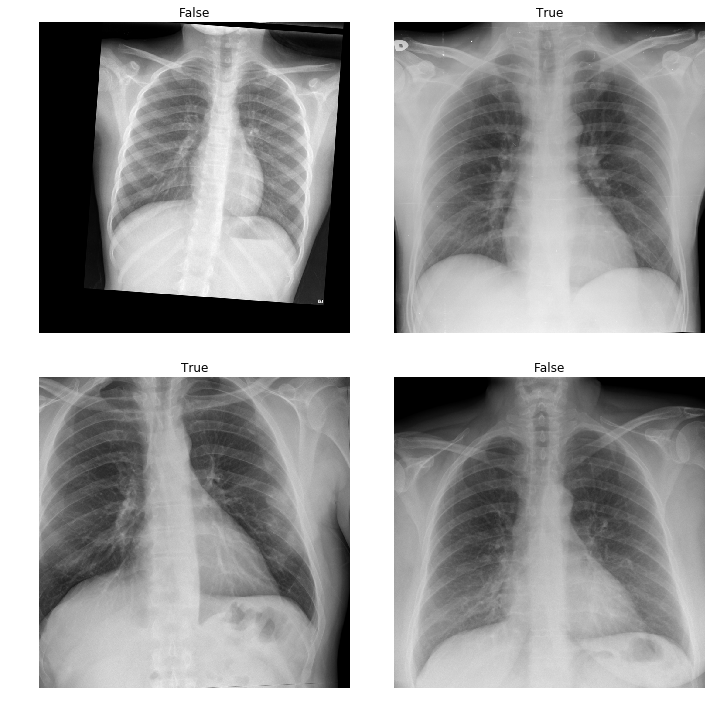

In [89]:
data.show_batch(rows=2, figsize=(10,10))


In [90]:
data.classes

[False, True]

False
ImageID     163990977153422026301903320805632535488_a7p35b...
labels                                               [normal]
fracture                                                False
Name: 904, dtype: object


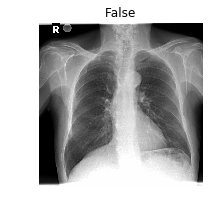

In [91]:
#show one study example from validation set
img,labels = data.valid_ds[-6]
print(labels)
print(df_final.loc[val.index.values[-6],])
img.show(title=labels)


In [92]:
class AverageMetric(Callback):
    def __init__(self, func):
        self.func, self.name = func, func.__name__

    def on_epoch_begin(self, **kwargs):
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, train, **kwargs):
        self.count += last_target.size(0)
        self.val += last_target.size(0) * self.func(last_output, last_target).detach().item()

    def on_epoch_end(self, **kwargs):
        self.metric = self.val/self.count


In [121]:
class Precision(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==1) * (last_target==1)).float().sum()
        self.total += (preds==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        self.metric = self.correct/self.total
        
class Recall(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==1) * (last_target==1)).float().sum()
        self.total += (last_target==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        self.metric = self.correct/self.total

In [81]:
from fastai.imports import *
from sklearn.metrics import fbeta_score
import warnings
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return torch.tensor(max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)]))
def f2_micro(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='micro')
                    for th in np.arange(start,end,step)])
def f2_macro(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='macro')
                    for th in np.arange(start,end,step)])
def f2_w(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='weighted')
                    for th in np.arange(start,end,step)])

In [94]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta = 1)
f_score1 = partial(fbeta, thresh=0.1, beta = 1)
#metrics = listify([acc_02,f_score,f2_w, f_score1])
learn = create_cnn(data, 
                   models.resnet18,
                   metrics=[accuracy,  Precision(), Recall()]).to_fp16()#, f2_micro, f2_macro, f2_w])



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


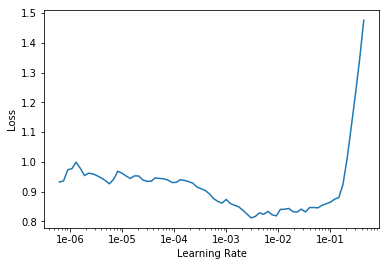

In [95]:

learn.lr_find()
learn.recorder.plot()

In [99]:
learn.unfreeze()

In [96]:
learn.fit_one_cycle(1, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,precision,recall
1,0.640859,0.558706,0.723077,0.820895,0.877551


In [142]:
learn.save('predict-rib-1')

In [143]:
learn.load('predict-rib-1')
1

1

In [ ]:
lr = 1e-2
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit_one_cycle(max_lr = lrs,  cyc_len=1)

In [ ]:
doc(create_cnn)

In [123]:
learn.unfreeze()


In [100]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


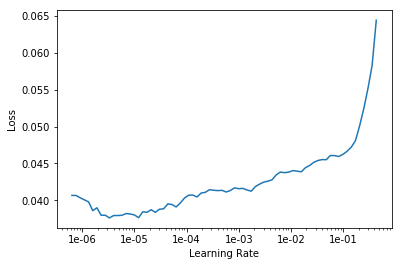

In [119]:
learn.recorder.plot()

In [101]:
learn.loss_func.func

CrossEntropyLoss()

In [126]:
learn.fit_one_cycle(30, max_lr=slice(1e-6,5e-6))

epoch,train_loss,valid_loss,accuracy,precision,recall
1,0.530703,0.413128,0.810256,0.738095,0.663265
2,0.579325,0.430784,0.805128,0.732283,0.653061
3,0.557445,0.403079,0.820513,0.750000,0.683673
4,0.560127,0.395342,0.830769,0.762295,0.704082
5,0.560940,0.391609,0.830769,0.762295,0.704082
6,0.562769,0.390875,0.835897,0.768595,0.714286
7,0.542928,0.395300,0.830769,0.762295,0.704082
8,0.555250,0.393313,0.835897,0.768595,0.714286
9,0.528648,0.360651,0.856410,0.800000,0.765306
10,0.514350,0.364293,0.856410,0.794872,0.755102


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f48573f1488>
Traceback (most recent call last):
  File "/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f48573f1488>
Traceback (most recent call last):
  File "/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/torch/u

In [144]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)


In [145]:
interp.top_losses()


(tensor([4.2343e+00, 3.4332e+00, 3.1530e+00, 2.5132e+00, 2.2924e+00, 2.1709e+00,
         2.0714e+00, 1.9277e+00, 1.8074e+00, 1.7463e+00, 1.7234e+00, 1.3741e+00,
         1.3727e+00, 1.2524e+00, 1.1786e+00, 1.1510e+00, 1.1478e+00, 1.1293e+00,
         1.0858e+00, 8.8848e-01, 8.0134e-01, 7.9476e-01, 7.4595e-01, 6.8658e-01,
         6.7476e-01, 6.6713e-01, 6.4915e-01, 6.4365e-01, 6.0053e-01, 5.9959e-01,
         5.5483e-01, 5.3759e-01, 4.9336e-01, 4.9047e-01, 4.8599e-01, 4.8136e-01,
         4.7995e-01, 4.6981e-01, 4.4717e-01, 4.3538e-01, 4.1279e-01, 3.8883e-01,
         3.8204e-01, 3.7150e-01, 3.6356e-01, 3.6284e-01, 3.6174e-01, 3.5319e-01,
         3.4146e-01, 3.3704e-01, 3.3453e-01, 3.2166e-01, 3.1706e-01, 3.0682e-01,
         3.0656e-01, 3.0527e-01, 2.8253e-01, 2.6998e-01, 2.5914e-01, 2.4376e-01,
         2.4220e-01, 2.3845e-01, 2.3520e-01, 2.3449e-01, 2.3403e-01, 2.3049e-01,
         2.2170e-01, 2.1421e-01, 2.0678e-01, 2.0464e-01, 2.0311e-01, 2.0106e-01,
         1.8087e-01, 1.8043e

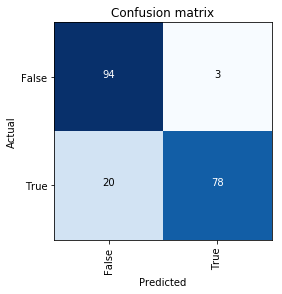

In [146]:
interp.plot_confusion_matrix()


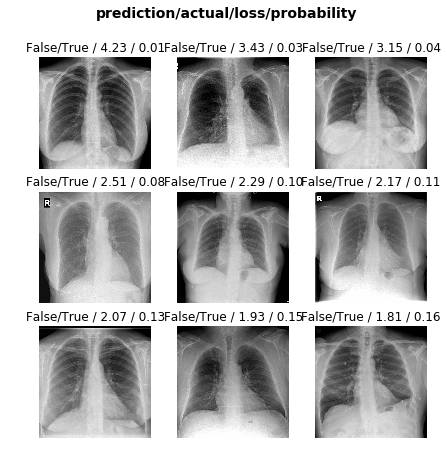

In [132]:
interp.plot_top_losses(9, figsize=(7,7))

In [133]:
interp.top_losses()[1][:20]

tensor([ 26,  20, 183,  52, 110,  68,  31, 144,  57,  88, 167,  42, 180,  73,
         97, 104,  11,  87,  83, 132])

ImageID     216840111366964013534861372972012362200920487_...
labels                        [rib fracture, chronic changes]
fracture                                                 True
Name: 277, dtype: object
Actual Rib Fracture: True
Predicted Rib Fracture: True


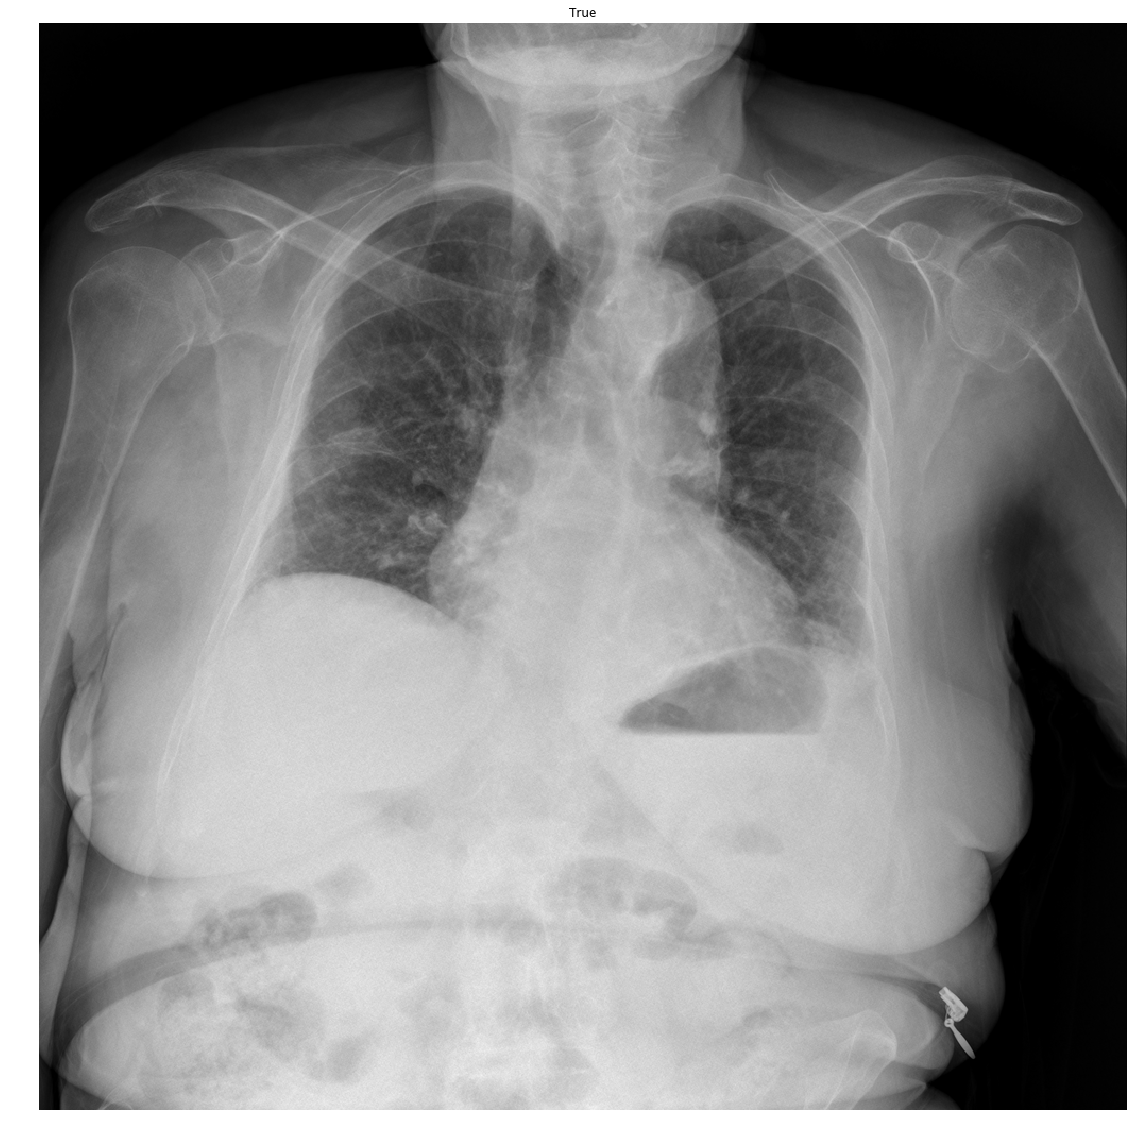

In [147]:
#Normal = 0, Fracture= 1 
item = 118
img,labels = data.valid_ds[item]

print(df_final.loc[val.index.values[item],])

print('Actual Rib Fracture: {}'.format(bool(labels)))
predicted = bool(np.argmax(preds[item], axis=0))
print('Predicted Rib Fracture: {}'.format(predicted))
img.show(title=labels, figsize=(20,20) )